# Neural network model to predict TA
Created by Ivan Lima on Mon Jan 23 2023 22:46:48 -0500

**This version of the neural network model does not include dissolved oxygen and satellite data as input features.**

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Jul 24 20:21:41 2023


In [2]:
import sns_settings
sns.set_context('paper')
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Load TA bottle data

In [3]:
df_bottle_ta = pd.read_csv('data/bottle_data_TA_prepared.csv', parse_dates=['Date'], index_col=0, na_values=['<undefined>',-9999.])
df_bottle_ta['log_Chl'] = np.log(df_bottle_ta.Chl)
df_bottle_ta['log_KD490'] = np.log(df_bottle_ta.KD490)

## Select input features and target variable

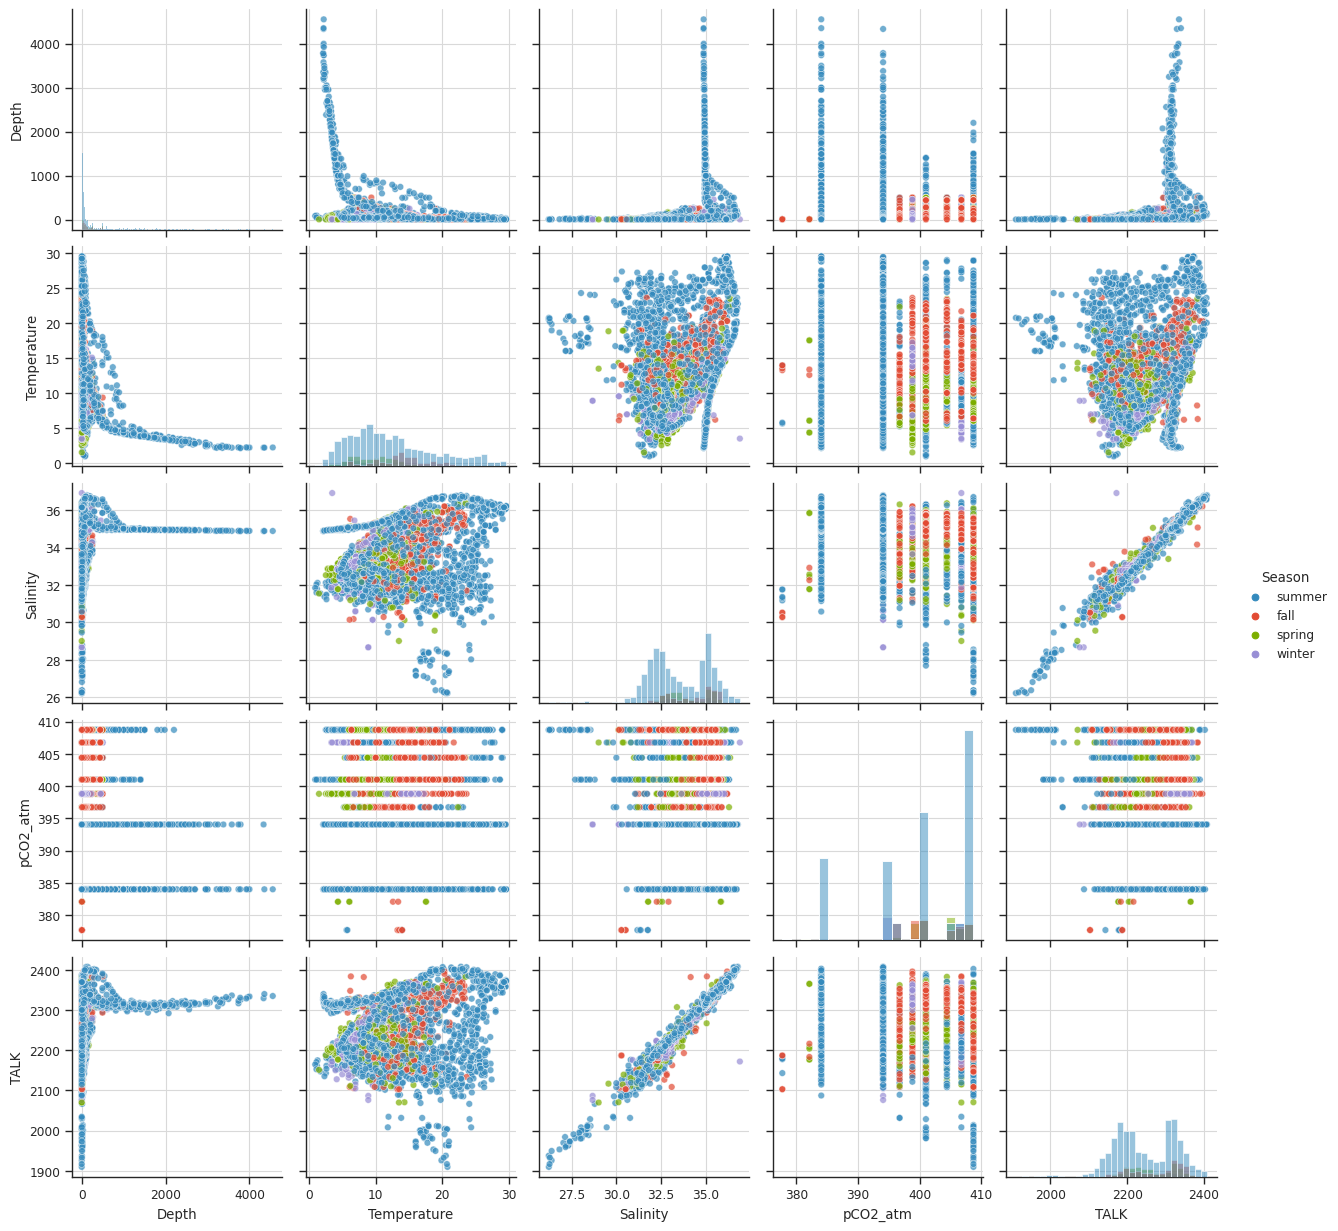

In [4]:
features = ['Depth', 'Temperature', 'Salinity', 'pCO2_atm']
target = ['TALK']
varlist = features + target
fg = sns.pairplot(df_bottle_ta, vars=varlist, hue='Season', plot_kws={'alpha':0.7}, diag_kind='hist')

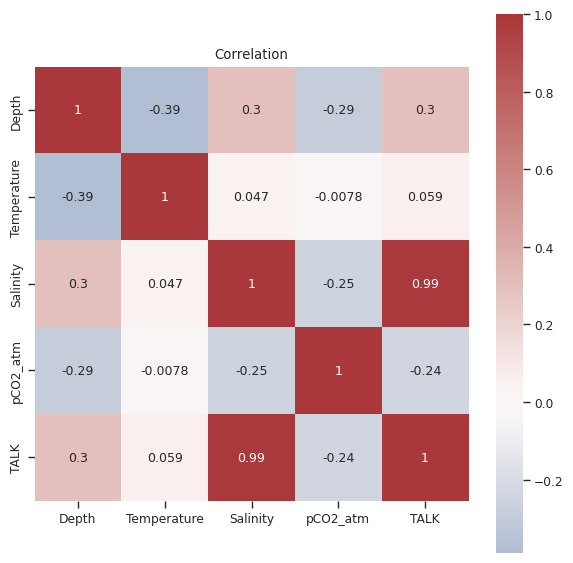

In [5]:
data = df_bottle_ta[varlist]
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.heatmap(corr_mat, ax=ax, cmap='vlag', center=0, square=True, annot=True, annot_kws={'fontsize':9})
_ = ax.set_title('Correlation')

## Split data into training and test sets 

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score

data = df_bottle_ta[features + target + ['Season']].dropna()

X = data[features].values
y = data[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=data.Season.values, random_state=77)
X.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4151, 4), (3113, 4), (1038, 4), (3113, 1), (1038, 1))

## Train Neural Network regression 

In [7]:
import tensorflow as tf
from tensorflow import keras

keras.utils.set_random_seed(42) # make things reproducible
n_hidden = 256 # number of nodes in hidden layers
alpha=0.01

model = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, input_shape=X_train.shape[1:]),
    keras.layers.LeakyReLU(alpha=alpha),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden),
    keras.layers.LeakyReLU(alpha=alpha),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(y_train.shape[1])
])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())
history = model.fit(X_train, y_train, epochs=700, verbose=2, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/700


2023-07-24 20:22:04.343219: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


78/78 - 1s - loss: 5058152.5000 - val_loss: 4826869.5000 - 1s/epoch - 16ms/step
Epoch 2/700
78/78 - 0s - loss: 5024779.0000 - val_loss: 4675571.0000 - 212ms/epoch - 3ms/step
Epoch 3/700
78/78 - 0s - loss: 4959481.0000 - val_loss: 4727107.0000 - 212ms/epoch - 3ms/step
Epoch 4/700
78/78 - 0s - loss: 4857733.5000 - val_loss: 4667107.5000 - 224ms/epoch - 3ms/step
Epoch 5/700
78/78 - 0s - loss: 4721133.0000 - val_loss: 4553366.0000 - 217ms/epoch - 3ms/step
Epoch 6/700
78/78 - 0s - loss: 4552999.0000 - val_loss: 4386781.0000 - 219ms/epoch - 3ms/step
Epoch 7/700
78/78 - 0s - loss: 4357344.0000 - val_loss: 4223865.0000 - 218ms/epoch - 3ms/step
Epoch 8/700
78/78 - 0s - loss: 4138198.7500 - val_loss: 4003955.5000 - 217ms/epoch - 3ms/step
Epoch 9/700
78/78 - 0s - loss: 3899918.0000 - val_loss: 3768097.2500 - 225ms/epoch - 3ms/step
Epoch 10/700
78/78 - 0s - loss: 3646812.7500 - val_loss: 3509264.7500 - 218ms/epoch - 3ms/step
Epoch 11/700
78/78 - 0s - loss: 3383293.7500 - val_loss: 3255060.7500 - 2

### Save trained model

In [8]:
model.save('models/nn_regression_ta_nosat.h5')

### Learning curve

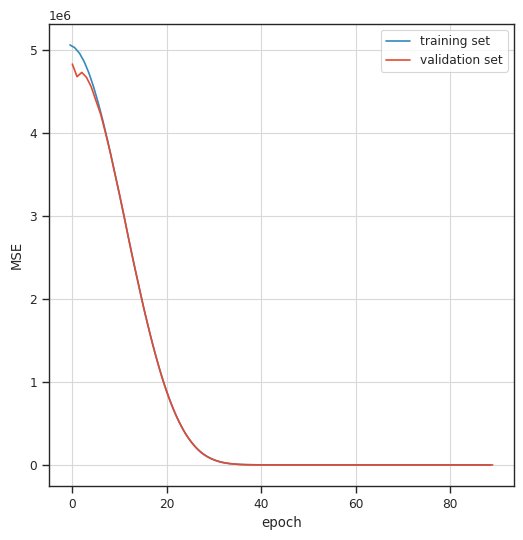

In [9]:
df_history = pd.DataFrame(history.history)
df_history.index.name = 'epoch'
df_history = df_history.reset_index()
df_history.to_csv('results/nn_regression_history_ta_nosat.csv')

fig, ax = plt.subplots(figsize=(6, 6))
_ = sns.lineplot(x=df_history.epoch-0.5, y='loss', data=df_history, ax=ax, label='training set')
_ = sns.lineplot(x=df_history.epoch, y='val_loss', data=df_history, ax=ax, label='validation set')
_ = ax.set(ylabel = 'MSE')
# _ = ax.set(yscale='log')

### MSE & $R^2$

In [10]:
from sklearn.metrics import r2_score

print('MSE on training set = {:.2f}'.format(model.evaluate(X_train, y_train, verbose=0)))
print('MSE on test set     = {:.2f}\n'.format(model.evaluate(X_test, y_test, verbose=0)))

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('R squared on training set = {:.3f}'.format(r2_score(y_train, y_pred_train)))
print('R squared on test set     = {:.3f}'.format(r2_score(y_test, y_pred_test)))

MSE on training set = 104.50
MSE on test set     = 107.46

R squared on training set = 0.982
R squared on test set     = 0.983


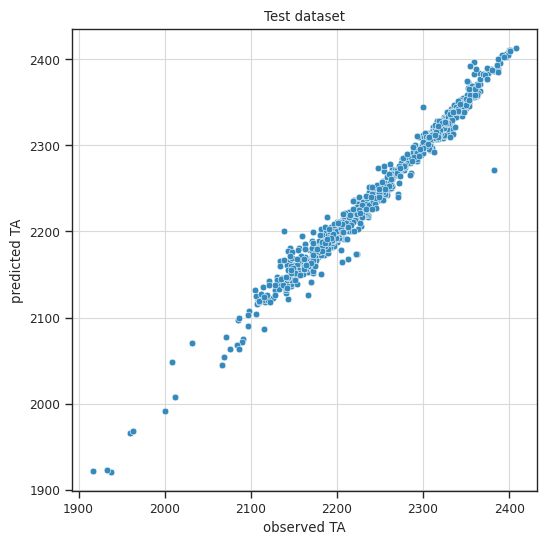

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
_ = sns.scatterplot(x=y_test.ravel(), y=y_pred_test.ravel(), ax=ax)
_ = ax.set(xlabel='observed TA', ylabel='predicted TA', title='Test dataset')
_ = ax.axis('equal')

In [12]:
# save test set features, target & predictions
df_test = pd.DataFrame(np.c_[X_test, y_test, y_pred_test], columns = features + ['TA observed', 'TA predicted'])
df_test['TA residuals'] = df_test['TA observed'] - df_test['TA predicted']
df_test.to_csv('results/bottle_data_test_ta_nosat.csv')

## K-fold cross-validation

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
score_vals = [] # store score values

nn_reg = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, input_shape=X_train.shape[1:]),
    keras.layers.LeakyReLU(alpha=alpha),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden),
    keras.layers.LeakyReLU(alpha=alpha),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(y_train.shape[1])
])
nn_reg.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

for k, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    X_tr, X_te = X_train[train_idx], X_train[test_idx]
    y_tr, y_te = y_train[train_idx], y_train[test_idx]
    history_cv = nn_reg.fit(X_tr, y_tr, epochs=700, verbose=0, validation_split=0.2, callbacks=[early_stopping_cb])
    y_pred = nn_reg.predict(X_te)
    score = r2_score(y_te, y_pred)
    score_vals.append(score)
    print('Fold {} test set R squared: {:.3f}'.format(k+1, score))

scores = np.array(score_vals)
print('\nBest R squared:  {:.3f}'.format(scores.max()))
print('Worst R squared: {:.3f}'.format(scores.min()))
print('Mean R squared:  {:.3f}'.format(scores.mean()))

Fold 1 test set R squared: 0.973
Fold 2 test set R squared: 0.983
Fold 3 test set R squared: 0.982
Fold 4 test set R squared: 0.981
Fold 5 test set R squared: 0.980

Best R squared:  0.983
Worst R squared: 0.973
Mean R squared:  0.980
